<a href="https://www.kaggle.com/code/nobertpratama1/bert-nlp-sentiment-analysis-project?scriptVersionId=131729569" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [42]:
import numpy as np
import pandas as pd
import torch
import bz2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [11]:
torch.__version__

'1.13.0'

In [12]:
#train = bz2.BZ2File('../input/amazonreviews/train.ft.txt.bz2')
#test = bz2.BZ2File('../input/amazonreviews/test.ft.txt.bz2')

In [13]:
#train = train.readlines()
#test = test.readlines()

In [14]:
#len(train)

In [15]:
#train[0:5]

In [16]:
def get_labels_and_texts(file):
    labels = []
    texts = []
    count = 0
    for line in bz2.BZ2File(file):
        x = line.decode("utf-8")
        labels.append(int(x[9]) - 1)
        texts.append(x[10:].strip())
        count += 1
        if count > 1500000:
            break
    return np.array(labels), texts

In [17]:
train_labels, train_texts = get_labels_and_texts('../input/amazonreviews/train.ft.txt.bz2')
test_labels, test_texts = get_labels_and_texts('../input/amazonreviews/test.ft.txt.bz2')

In [18]:
train_labels[0:5]

array([1, 1, 1, 1, 1])

In [19]:
train_texts[0:5]

['Stuning even for the non-gamer: This sound track was beautiful! It paints the senery in your mind so well I would recomend it even to people who hate vid. game music! I have played the game Chrono Cross but out of all of the games I have ever played it has the best music! It backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. It would impress anyone who cares to listen! ^_^',
 "The best soundtrack ever to anything.: I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny.",
 'Amazing!: This soundtrack is my favorite music of all

In [20]:
type(train_texts)

list

In [21]:
type(train_labels)

numpy.ndarray

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts,train_labels,test_size=0.2,stratify=train_labels)

In [24]:
len(train_texts)

1200000

In [25]:
len(val_texts)

300001

In [26]:
len(test_texts)

400000

In [27]:
unique, counts = np.unique(train_labels, return_counts=True)
print(unique)
print(counts)

[0 1]
[596318 603682]


In [28]:
unique, counts = np.unique(val_labels, return_counts=True)
print(unique)
print(counts)

[0 1]
[149080 150921]


In [29]:
unique, counts = np.unique(test_labels, return_counts=True)
print(unique)
print(counts)

[0 1]
[200000 200000]


In [30]:
from transformers import AutoTokenizer, DistilBertForSequenceClassification

from torch.utils.data import DataLoader

In [31]:
class AmazonDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, max_seq_length, model_name):
        self.texts = texts
        self.labels = labels
        self.max_seq_length = max_seq_length
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, index):
        # Get a single line of text based on index
        text = self.texts[index]
        
        # Get a single line of encoded text
        encoded_text = self.tokenizer.encode_plus(text, 
                                                  add_special_tokens=True, 
                                                  pad_to_max_length=True, 
                                                  max_length=self.max_seq_length,
                                                  truncation=True,
                                                  )
        
        out_dict = {"input_ids" : torch.tensor(encoded_text["input_ids"], dtype=torch.long), 
                    "attention_mask" : torch.tensor(encoded_text["attention_mask"], dtype=torch.long),
                   "label" : torch.tensor(self.labels[index], dtype=torch.long)}
        
        return out_dict

In [32]:
train_dataset = AmazonDataset(texts=train_texts, labels=train_labels, max_seq_length=256, model_name="distilbert-base-uncased")

In [33]:
train_dataset[2000]

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'input_ids': tensor([  101,  6919,  2338,  1024,  2023,  2003,  1996,  2190,  2338,  2005,
          3087,  2383,  1037,  3336,  2879,  1012,  2074,  4299,  2027,  2626,
          2028,  2005,  3336,  2611,  1000,  1055,  1012,  2026, 12286,  3866,
          2009,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [34]:
val_dataset = AmazonDataset(texts=val_texts, labels=val_labels, max_seq_length=256, model_name="distilbert-base-uncased")

In [35]:
test_dataset = AmazonDataset(texts=test_texts, labels=test_labels, max_seq_length=256, model_name="distilbert-base-uncased")

In [36]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [37]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=2)
model.to(device)

In [ ]:
# Freeze DistilBERT layers
for params in model.distilbert.parameters():
    params.requires_grad = False

In [ ]:
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
epochs = 1
for epoch in range(epochs):
    
    train_loss = 0
    val_loss = 0
    val_acc = 0
    train_acc = 0
    model.train()
    for batch in tqdm(train_loader):
        
        
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
    
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        #print(outputs.logits.argmax(dim=-1).sum().item())
        #pred_labels_logits = outputs.logits.argmax(dim=1)
        pred_labels = torch.nn.functional.softmax(outputs.logits, dim=1).argmax(dim=1)
        
        train_acc += (pred_labels == labels).sum().item()
        #loss = criterion(outputs.logits, labels)
        loss = outputs.loss
        #print(loss)
        
        
        loss.backward()
        
        optimizer.step()
        train_loss += loss.item()
        
    print(f"Epoch: {epoch}")
    train_acc = (train_acc / len(train_dataset))* 100
    print(f"Train Accuracy: {train_acc}")
    
    train_loss /= len(train_loader) 
    print(f"Train Loss: {train_loss}")
    
    # Validation
    model.eval()
    with torch.no_grad():
        for val_batch in tqdm(val_loader):
            input_ids = val_batch['input_ids'].to(device)
            attention_mask = val_batch['attention_mask'].to(device)
            labels = val_batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            #print(outputs)
            pred_labels = torch.nn.functional.softmax(outputs.logits, dim=1).argmax(dim=1)
            loss = outputs.loss
            val_loss += loss.item()
            #print(loss)
            
            #print(outputs[1])
            
            #pred_label = torch.argmax(outputs[1], dim=1).tolist()
            #print(pred_label)
            
            val_acc += (pred_labels == labels).sum().item()
            
    val_acc = (val_acc / len(val_dataset)) * 100
    print(f"Validation Accuracy: {val_acc}")
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss}")

# Load Saved Model

In [38]:
model = torch.load("/kaggle/input/distilbert-sentiment-analysis-epoch-2/distil_bert_sentiment_analysis_epoch_2.pth",map_location=torch.device(device))

In [39]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [40]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [43]:
# count = 0
inference_test = []
true_labels = []

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        test_input = batch['input_ids'].to(device)
        test_a_mask = batch['attention_mask'].to(device)
        test_label = batch['label'].to(device)
        #print(test_input.shape)
        #print(test_a_mask.shape)

        pred = model(test_input, attention_mask=test_a_mask)
        pred = torch.nn.functional.softmax(pred.logits, dim=1).argmax(dim=1)
        #print(pred.tolist())
        inference_test.extend(pred.tolist())
        true_labels.extend(test_label.tolist())
        #print(true_labels)
        #print(test_label)
    #     count += 1
    #     if count > 10:
    #         break

100%|██████████| 3125/3125 [26:39<00:00,  1.95it/s]


In [44]:
len(inference_test)

400000

In [45]:
len(true_labels)

400000

In [46]:
cm = confusion_matrix(true_labels, inference_test)

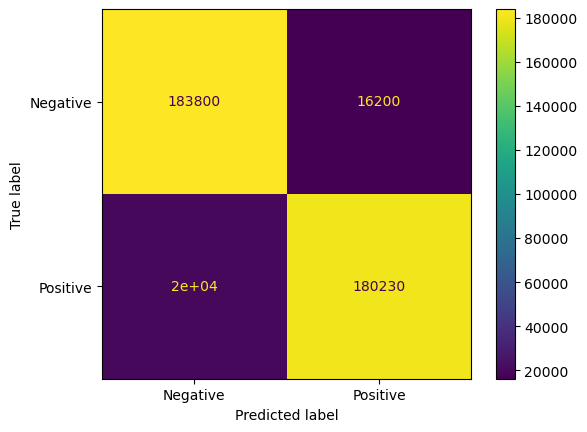

In [47]:
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot()

In [48]:
test_acc = accuracy_score(true_labels, inference_test)
test_precision = precision_score(true_labels, inference_test)
test_recall = recall_score(true_labels, inference_test)

In [49]:
tn, fp, fn, tp = cm.ravel()
test_specificity = tn / (tn+fp)

In [50]:
test_f1 = f1_score(true_labels, inference_test)

In [51]:
print(f"Test Accuracy: {test_acc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test Specificity: {test_specificity}")
print(f"Test F1 Score: {test_f1}")

Test Accuracy: 0.910075
Test Precision: 0.9175278725245635
Test Recall: 0.90115
Test Specificity: 0.919
Test F1 Score: 0.9092651918371466


In [ ]:
# torch.save({"optimizer_state_dict" : optimizer.state_dict()},"optimizer-state.pth")